### Split dataset into train, test, validation sets, separately for each target. 

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import pickle, random, os, glob
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Set random seed
random.seed(0)

#Input data
cancer_type_df = pickle.load(open('TCGA_Metadata/TCGA_cancer_types_binary.p','rb'))
t14_df = pd.read_csv('TCGA_Metadata/TCGA_T14_patients.csv')
n03_df = pd.read_csv('TCGA_Metadata/TCGA_N03_patients.csv')
m01_df = pd.read_csv('TCGA_Metadata/TCGA_M01_patients.csv')
path_report_text = pd.read_csv('TCGA_Pathology_Reports/TCGA_Reports.csv')

#Instantiate output directories 
t14_output = 't14_data/' 
n03_output = 'n03_data/' 
m01_output = 'm01_data/' 
for output_directory in [t14_output, n03_output, m01_output]:
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

In [2]:
cancer_type_df.head(1)

,patient,type,patient_filename,BLCA,UCS,HNSC,STAD,CESC,DLBC,KIRC,UCEC,PRAD,SARC,THYM,KIRP,KICH,LIHC,BRCA,LUAD,PAAD,OV,THCA,MESO,ACC,CHOL,TGCT,LUSC,READ,SKCM,COAD,PCPG,UVM,ESCA,GBM,LGG
0,TCGA-OR-A5J1,ACC,TCGA-OR-A5J1.8866FD87-4F6F-4D7E-B99A-7DD427ED3BB3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### T14

In [3]:
t14_patient_df = cancer_type_df[cancer_type_df['patient'].isin(list(t14_df['case_submitter_id']))].copy()
#print(t14_patient_df.shape)
t14_patient_df.reset_index(inplace=True, drop=True)
t14_patient_df['case_submitter_id']=t14_patient_df['patient']

In [4]:
t14_merged_df = t14_patient_df.merge(t14_df, on='case_submitter_id')[['type','patient_filename','ajcc_pathologic_t','case_submitter_id']]
t14_merged_df = t14_merged_df[t14_merged_df['ajcc_pathologic_t']!='T0']
t14_merged_df = t14_merged_df[t14_merged_df['ajcc_pathologic_t']!='TX']

t14_merged_df.reset_index(inplace=True, drop=True)
list_t=[]
for a_value in list(t14_merged_df['ajcc_pathologic_t']):
    if '1' in a_value:
        list_t.append(0)
    elif '2' in a_value:
        list_t.append(1)
    elif '3' in a_value:
        list_t.append(2)
    elif '4' in a_value:
        list_t.append(3)
    else:
        print(a_value) #Check for any unrecognized terms 

In [5]:
t14_merged_df['t'] = list_t

In [6]:
print('Number of cancer types in TCGA, train/val/test:',len(set(t14_merged_df['type'])))

Number of cancer types in TCGA, train/val/test: 23


In [7]:
overall_counts_t14 = pd.DataFrame({'label':[0,1,2,3],
                              't14_patient_count': [t14_merged_df[t14_merged_df['t']==label].shape[0] for label in [0,1,2,3] ]})
overall_counts_t14

,label,t14_patient_count
0,0,1746
1,1,2336
2,2,2112
3,3,693


In [8]:
t14_merged_df[t14_merged_df['t']==0]

,type,patient_filename,ajcc_pathologic_t,case_submitter_id,t
12,ACC,TCGA-OR-A5JE.80EDB29A-262A-486D-B31A-EA015FA8A362,T1,TCGA-OR-A5JE,0
16,ACC,TCGA-OR-A5JI.F18AFE4B-5333-418A-A6D0-E347ACA3C06B,T1,TCGA-OR-A5JI,0
19,ACC,TCGA-OR-A5JL.BD8435C3-C525-472C-8B43-EC2CAE22B785,T1,TCGA-OR-A5JL,0
21,ACC,TCGA-OR-A5JO.1FECADEA-0B65-451D-933D-2217F9119D35,T1,TCGA-OR-A5JO,0
23,ACC,TCGA-OR-A5JR.33E0DEF4-2538-4C8B-A71C-11B4F9D57E32,T1,TCGA-OR-A5JR,0
...,...,...,...,...,...
6807,THCA,TCGA-KS-A4I5.801C7861-F776-44D4-A594-4303B4F8A3F7,T1b,TCGA-KS-A4I5,0
6808,THCA,TCGA-KS-A4I7.819E8C9B-A49F-450A-A55D-19BF97E3F9ED,T1b,TCGA-KS-A4I7,0
6809,THCA,TCGA-KS-A4I9.C4D74382-93BC-4798-83C5-DD669AD67794,T1b,TCGA-KS-A4I9,0
6811,THCA,TCGA-KS-A4IC.64802136-E632-4C35-9CE6-C1CC1F7E6022,T1b,TCGA-KS-A4IC,0


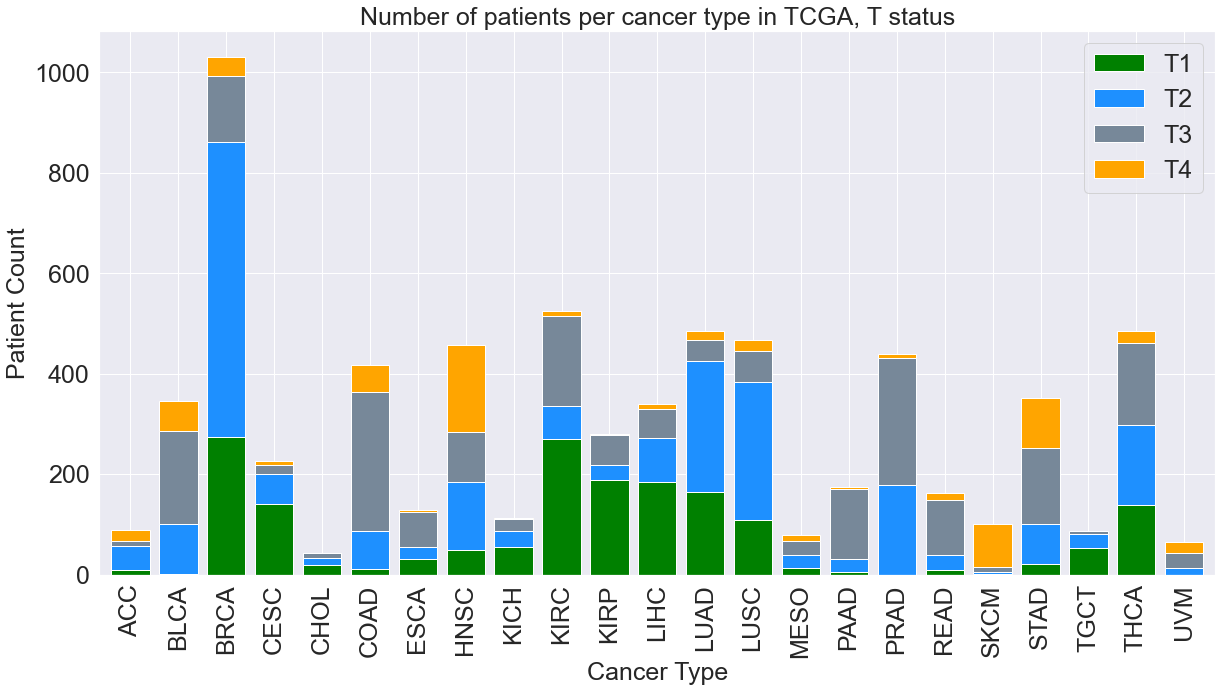

In [9]:
count_df = t14_merged_df.groupby(['type','t']).count()[['case_submitter_id']]
count_df.rename({'case_submitter_id':'patient_count'}, axis=1,inplace=True)
count_df.sort_values('type', )
sns.set(rc={'figure.figsize':(10,6)})
count_df.unstack(1).plot(figsize=(20, 10),width=.8, fontsize=25,
                         kind='bar', stacked=True,color=['green','DodgerBlue','lightslategray', 'orange'])
plt.title('Number of patients per cancer type in TCGA, T status',fontsize=25)
plt.ylabel('Patient Count',fontsize=25)
plt.xlabel('Cancer Type',fontsize=25)
plt.legend(['T1','T2','T3','T4'],fontsize=25)
plt.savefig('patient_count_T14.png',dpi=900, bbox_inches='tight')
plt.show()

In [10]:
def process_reports(target_name, final_target_df):

    target_col = target_name[0].lower()

    final_df = final_target_df[['patient_filename', target_col]] 
    shuffled_df = final_df.sample(frac=1, random_state = 0)
    train, test = train_test_split(shuffled_df, test_size=0.15, stratify=shuffled_df[target_col], random_state = 0)
    text_list, approx_n_tokens = [],[]

    train_text_list = []
    for patient in list(train['patient_filename']):
        train_text_list.append(path_report_text[path_report_text['patient_filename']==patient]) 
        
    train['text'] = train_text_list
    #Rename column
    train.rename({target_name:'label'},axis=1, inplace=True)
    
    #Save as pickle
    #pickle.dump(test,open(output_directory + 'Target_Data_'+ target_name + '.p','wb'))

    #Save as csv 
    #test.to_csv(output_directory+ 'Target_Data_' + target_name + '.csv', index=False)

    test_text_list = []
    for patient in list(test['patient_filename']):
        test_text_list.append(path_report_text[path_report_text['patient_filename']==patient]) 

    test['text'] = test_text_list
    
    #Rename column
    test.rename({target_name:'label'},axis=1, inplace=True)

    #Save as pickle
    #pickle.dump(test,open(output_directory + 'Target_Data_'+ target_name + '_test.p','wb'))

    #Save as csv 
    #test.to_csv(output_directory+ 'Target_Data_' + target_name + '_test.csv', index=False)


    print('Number of patients in ', target_name, 'Train/Val Set:', train.shape[0])
    print('Numebr of patients in ', target_name, 'Test Set:', test.shape[0]) 

In [11]:
process_reports('T14', t14_merged_df)

Number of patients in  T14 Train/Val Set: 5853
Numebr of patients in  T14 Test Set: 1034


### N03

In [12]:
n03_patient_df = cancer_type_df[cancer_type_df['patient'].isin(list(n03_df['case_submitter_id']))].copy()
#print(n03_patient_df.shape)
n03_patient_df.reset_index(inplace=True, drop=True)
n03_patient_df['case_submitter_id']=n03_patient_df['patient']

In [13]:
n03_merged_df = n03_patient_df.merge(n03_df, on='case_submitter_id')[['type','patient_filename','ajcc_pathologic_n','case_submitter_id']]
n03_merged_df = n03_merged_df[n03_merged_df['ajcc_pathologic_n']!='NX']
n03_merged_df = n03_merged_df[n03_merged_df['ajcc_pathologic_n']!='N0 (i+)']
n03_merged_df = n03_merged_df[n03_merged_df['ajcc_pathologic_n']!='N0 (i-)']
n03_merged_df = n03_merged_df[n03_merged_df['ajcc_pathologic_n']!='N0 (mol+)']


n03_merged_df.reset_index(inplace=True, drop=True)
list_n=[]
for a_value in list(n03_merged_df['ajcc_pathologic_n']):
    if a_value == 'N0':
        list_n.append(0)
    elif '1' in a_value:
        list_n.append(1)
    elif '2' in a_value:
        list_n.append(2)
    elif '3' in a_value:
        list_n.append(3)
    else:
        print(a_value) #Check for any unrecognized terms 

In [14]:
n03_merged_df['n'] = list_n 

In [15]:
print('Number of cancer types in TCGA, train/val/test:',len(set(n03_merged_df['type'])))

Number of cancer types in TCGA, train/val/test: 23


In [16]:
overall_counts_n03 = pd.DataFrame({'label':[0,1,2,3],
                              'n03_patient_count': [n03_merged_df[n03_merged_df['n']==label].shape[0] for label in [0,1,2,3] ]})
overall_counts_n03

,label,n03_patient_count
0,0,3329
1,1,1460
2,2,693
3,3,196


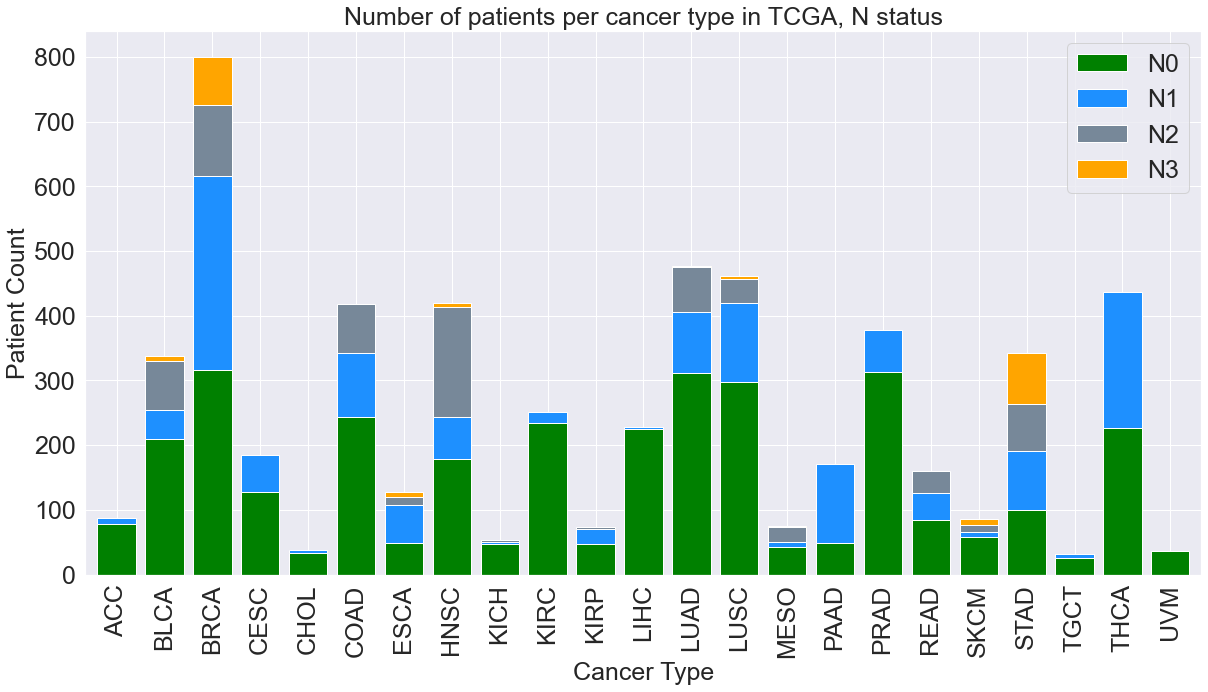

In [17]:
count_df = n03_merged_df.groupby(['type','n']).count()[['case_submitter_id']]
count_df.rename({'case_submitter_id':'patient_count'}, axis=1,inplace=True)
count_df.sort_values('type', )
sns.set(rc={'figure.figsize':(10,6)})
count_df.unstack(1).plot(figsize=(20, 10),width=.8, fontsize=25,
                         kind='bar', stacked=True,color=['green','DodgerBlue','lightslategray', 'orange','violet'])
plt.title('Number of patients per cancer type in TCGA, N status',fontsize=25)
plt.ylabel('Patient Count',fontsize=25)
plt.xlabel('Cancer Type',fontsize=25)
plt.legend(['N0','N1','N2','N3'],fontsize=25)

plt.savefig('patient_count_N03.png',dpi=900, bbox_inches='tight')
plt.show()

In [18]:
process_reports('N03', n03_merged_df)

Number of patients in  N03 Train/Val Set: 4826
Numebr of patients in  N03 Test Set: 852


### M01 

In [19]:
m01_patient_df = cancer_type_df[cancer_type_df['patient'].isin(list(m01_df['case_submitter_id']))].copy()
m01_patient_df.reset_index(inplace=True, drop=True)
m01_patient_df['case_submitter_id']=m01_patient_df['patient']

In [20]:
m01_merged_df = m01_patient_df.merge(m01_df, on='case_submitter_id')[['type','patient_filename','ajcc_pathologic_m','case_submitter_id']]
m01_merged_df = m01_merged_df[m01_merged_df['ajcc_pathologic_m']!='MX']

m01_merged_df.reset_index(inplace=True, drop=True)
list_m=[]
for a_value in list(m01_merged_df['ajcc_pathologic_m']):
    if '0' in a_value:
        list_m.append(0)
    elif '1' in a_value:
        list_m.append(1)
    else:
        print(a_value) #Check for any unrecognized terms 

In [21]:
m01_merged_df['m'] = list_m 

In [22]:
print('Number of cancer types in TCGA, train/val/test:',len(set(m01_merged_df['type'])))

Number of cancer types in TCGA, train/val/test: 21


In [24]:
overall_counts_m01 = pd.DataFrame({'label':[0,1],
                              'm01_patient_count': [m01_merged_df[m01_merged_df['m']==label].shape[0] for label in [0,1] ]})
overall_counts_m01

,label,m01_patient_count
0,0,4295
1,1,313


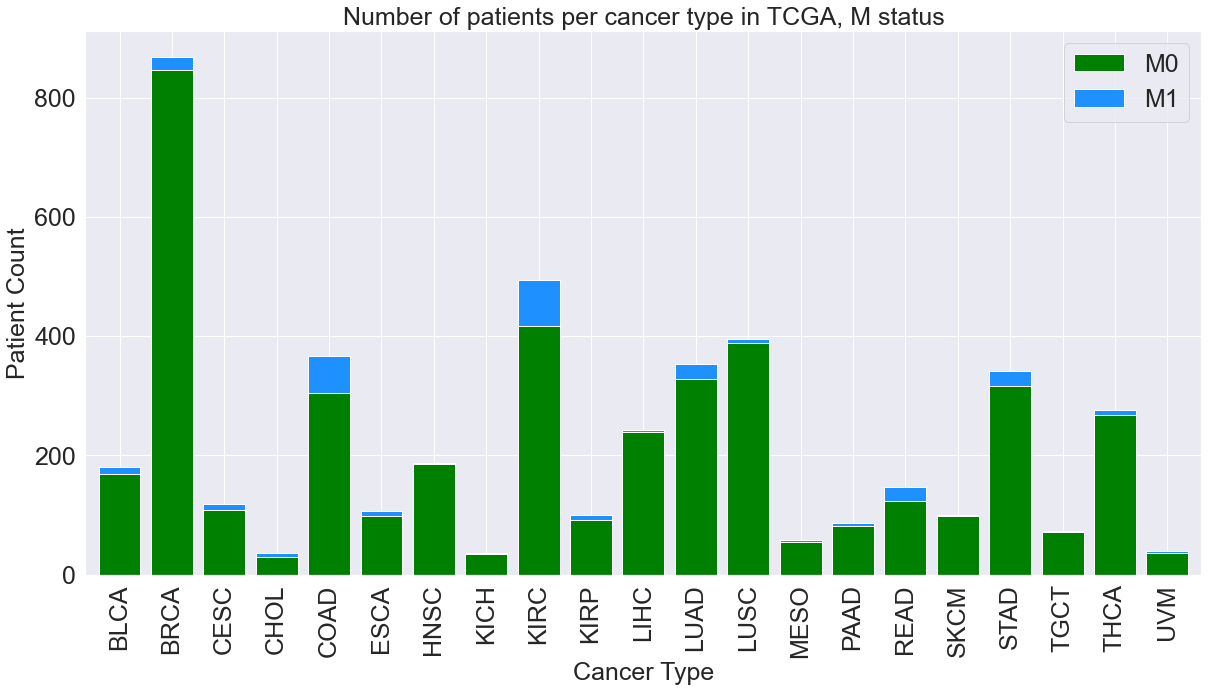

In [26]:
count_df = m01_merged_df.groupby(['type','m']).count()[['case_submitter_id']]
count_df.rename({'case_submitter_id':'patient_count'}, axis=1,inplace=True)
count_df.sort_values('type', )
sns.set(rc={'figure.figsize':(10,6)})
count_df.unstack(1).plot(figsize=(20, 10),width=.8, fontsize=25,
                         kind='bar', stacked=True,color=['green','DodgerBlue','lightslategray', 'orange','violet'])
plt.title('Number of patients per cancer type in TCGA, M status',fontsize=25)
plt.ylabel('Patient Count',fontsize=25)
plt.xlabel('Cancer Type',fontsize=25)
plt.legend(['M0','M1'],fontsize=25)

plt.savefig('patient_count_M01.png',dpi=900, bbox_inches='tight')
plt.show()

In [27]:
process_reports('M01', m01_merged_df)

Number of patients in  M01 Train/Val Set: 3916
Numebr of patients in  M01 Test Set: 692
